## Requirements

In [1]:
import functions
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from timeit import default_timer as timer
import matplotlib.pyplot as plt

## Gather Dataset

In [2]:
kaggleDatasetName = 'crowdflower/twitter-user-gender-classification'
functions.downloadDataset(kaggleDatasetName)
datasetFileName = functions.getDatasetFileName(kaggleDatasetName)    
df = pd.read_csv(datasetFileName, encoding="latin1", index_col=0)
df.head()

,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
_unit_id,,,,,,,,,,,,,,,,,,,,,
815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


## Which Variables to Use?
Obviously we will use `gender` since this is what we are trying to predict. `description` could be useful for the same reason as `text`. `sidebar_color` might be interesting, but I'm not sure whether to make it a factor variable, or put it on a scale somehow. My hypothesis for `tweet_count` is that if it is a very high number, then it is a brand Twitter account, so I will leave this in to test this hypothesis.

In [3]:
interestingColumns = ['gender', 'description','text','sidebar_color','tweet_count']
df = df[interestingColumns]
df.head()

,gender,description,text,sidebar_color,tweet_count
_unit_id,,,,,
815719226,male,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,FFFFFF,110964
815719227,male,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,C0DEED,7471
815719228,male,louis whining and squealing and all,i absolutely adore when louis starts the songs...,C0DEED,5617
815719229,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,C0DEED,1693
815719230,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,0,31462


## Cleaning the Data
First we will have to clean up the dataset by removing common words from the `description` and `text` columns. Then we will remove the URLs, because I am assuming there will not be many matching URLs. We will also remove tagging of other Twitter users e.g. '@JordanSpieth' for the same reason as URLs. Lastly we will remove characters that are not readable to us. <br>
However, we will not remove URLs or tagging entirely, because it will be interesting to see who shares links, or tags people the most<br>
We also will reclassify the gender variable as an integer for easier manipulating, and remove all entries where the gender cannot be verified because these will not help our model.


In [4]:
stoplist_name = "stoplist.txt"
with open(stoplist_name) as stop_file:
    stoplist = stop_file.read().splitlines()
stoplist = [word.replace("'", "") for word in stoplist]

df = df.replace(np.nan, '', regex=True)

tweets = df['text'].tolist()
descriptions = df['description'].tolist()

df['text'] = functions.cleanDataset(tweets)
df['description'] = functions.cleanDataset(descriptions)

df.loc[df['gender'] == 'brand', 'gender',] = 0
df.loc[df['gender'] == 'female', 'gender',] = 1
df.loc[df['gender'] == 'male', 'gender',] = 2
df = df[~df['gender'].isin(['unknown',''])]

## Number of Tweets

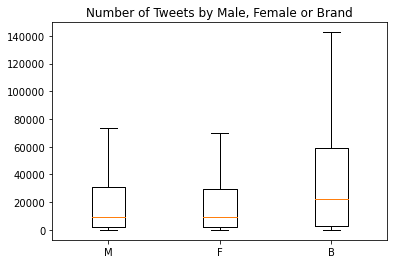

In [5]:
male = df.loc[df['gender'] == 2,'tweet_count'].values
female = df.loc[df['gender'] == 1,'tweet_count'].values
brand = df.loc[df['gender'] == 0,'tweet_count'].values

fig1, ax1 = plt.subplots()
ax1.set_title('Number of Tweets by Male, Female or Brand')
ax1.boxplot([male,female,brand], labels=['M','F','B'], showfliers=False)
plt.show()

From here we can see that male and female users tweet at approximately the same rate, whereas brand accounts tweet much more than the individual user. 

## Description Words

In [9]:
dfx = df['description']
dfy = df['gender']
cv = CountVectorizer(stop_words=stoplist)
x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=4)
x_traincv = cv.fit_transform(x_train)
train_arr = x_traincv.toarray()

x_testcv=cv.transform(x_test)

mnb = MultinomialNB()
y_train = y_train.values.astype(np.int64)
mnb.fit(x_traincv,y_train)

predictions=mnb.predict(x_testcv)

ystar = np.array(y_test)
acc_array = predictions==ystar
accuracy = np.sum(acc_array) / len(acc_array)
print('Accuracy: {}'.format(accuracy))

fnames = cv.get_feature_names()

mnbResultsDict = functions.constructResultsDictionary(mnb, fnames)
for i in mnbResultsDict:
    print(i, ': ', mnbResultsDict[i]['topWords'])

Accuracy: 0.5660828025477707
brand :  ['http', 'news', 'follow', 'twitter', 'updates', 'official', 'world', 'music', 'tweets', 'free']
female :  ['love', 'http', 'life', 'lover', 'girl', 'writer', 'music', 'time', 'world', 'ig']
male :  ['http', 'love', 'fan', 'life', 'music', 'sports', 'writer', 'man', 'follow', 'ig']


As we can see, the accuracy achieves about 56.6%, which is better than random guessing, but not great. Many of the same words pop up many times for multiple or all of the categories. Almost any user is likely to leave a URL in their description. The words 'love,' 'life,' 'music,' and 'writer' are some of the higher weighted words for both male and female users. There are some words that show distinction. Brands like to the words 'news,' 'follow,' 'updates,' and 'official' in their description, while a user is more likely to be female if they have the words 'lover,' or 'girl,' in their description. The same applies for male users using the words 'fan,' 'sports,' or 'man'<br>
The results also show that male and female users are likely to put their Instagram user in their Twitter description.